# Linear Discriminant Analysis from scratch

# Introduction

Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. 
The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting ("curse of dimensionality") and also reduce computational costs.

Ronald A. Fisher formulated the *Linear Discriminant* in 1936 ([The Use of Multiple  Measurements in Taxonomic Problems](http://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x/abstract)), and it also has some practical uses as classifier. The original Linear discriminant was described for a 2-class problem, and it was then later generalized as "multi-class Linear Discriminant Analysis" or "Multiple Discriminant Analysis" by C. R. Rao in 1948 ([The utilization of multiple measurements in problems of biological classification](http://www.jstor.org/stable/2983775))


**The general LDA approach is very similar to a Principal Component Analysis, but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA).**

So, in a nutshell, often the goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace $k$ (where $k \leq n-1$) while maintaining the class-discriminatory information.   
In general, dimensionality reduction does not only help reducing computational costs for a given classification task, but it can also be helpful to avoid overfitting by minimizing the error in parameter estimation ("curse of dimensionality").

## Principal Component Analysis vs. Linear Discriminant Analysis

Both **Linear Discriminant Analysis (LDA)** and **Principal Component Analysis (PCA)** are linear transformation techniques that are commonly used for dimensionality reduction. **PCA can be described as an "unsupervised"** algorithm, since it "ignores" class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset.
In contrast to PCA, **LDA is "supervised"** and computes the directions ("linear discriminants") that  will represent the axes that that maximize the separation between multiple classes.

Although it might sound intuitive that LDA is superior to PCA for a multi-class classification task where the class labels are known, this might not always the case.  
For example, comparisons between classification accuracies for image recognition after using PCA or LDA show that PCA tends to outperform LDA if the number of samples per class is relatively small ([PCA vs. LDA](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=908974), A.M. Martinez et al., 2001).
In practice, it is also not uncommon to use both LDA and PCA in combination: E.g., PCA for dimensionality reduction followed by an LDA.
<br>
<br>


<img src="https://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/Images/lda_1.png" width="500">



## What is a "good" feature subspace?

Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$). 
So, how do we know what size we should choose for $k$ ($k$ = the number of dimensions of the new feature subspace), and how do we know if we have a feature space that represents our data "well"?  

Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrices (i.e., the in-between-class scatter matrix and within-class scatter matrix).  
Each of these eigenvectors is associated with an eigenvalue, which tells us about the "length" or "magnitude" of the eigenvectors. 

If we would observe that all eigenvalues have a similar magnitude, then this may be a good indicator that our data is already projected on a "good" feature space.  

And in the other scenario, if some of the eigenvalues are much much larger than others, we might be interested in keeping only those eigenvectors with the highest eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider dropping those for constructing the new feature subspace.

## Summarizing the LDA approach in 6 steps

Listed below are the 6 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. Center points
2. Compute the $d$-dimensional mean vectors for the different classes from the dataset.
3. Compute the scatter matrices (in-between-class and within-class scatter matrix).
4. Compute the eigenvectors ($\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d$) and corresponding eigenvalues ($\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d$) for the scatter matrices.
5. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k$ dimensional matrix $\pmb W\;$ (where every column represents an eigenvector).
6. Use this $d \times k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication $\pmb Y = \pmb X \times \pmb W$ (where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb y$ are the transformed $n \times k$-dimensional samples in the new subspace).

<img src="https://media-exp1.licdn.com/dms/image/C4D12AQF2ZVi92nypDw/article-cover_image-shrink_720_1280/0?e=1606953600&v=beta&t=kMQvpWApHJJrgr9AcqZTxaY27jWRd5vtqq9uKY2V4Tg" width="500">

# Preparing the sample data set

## Open dataset

In [291]:
import seaborn as sns

df = sns.load_dataset("iris")

## Exploratory data analysis (EDA)

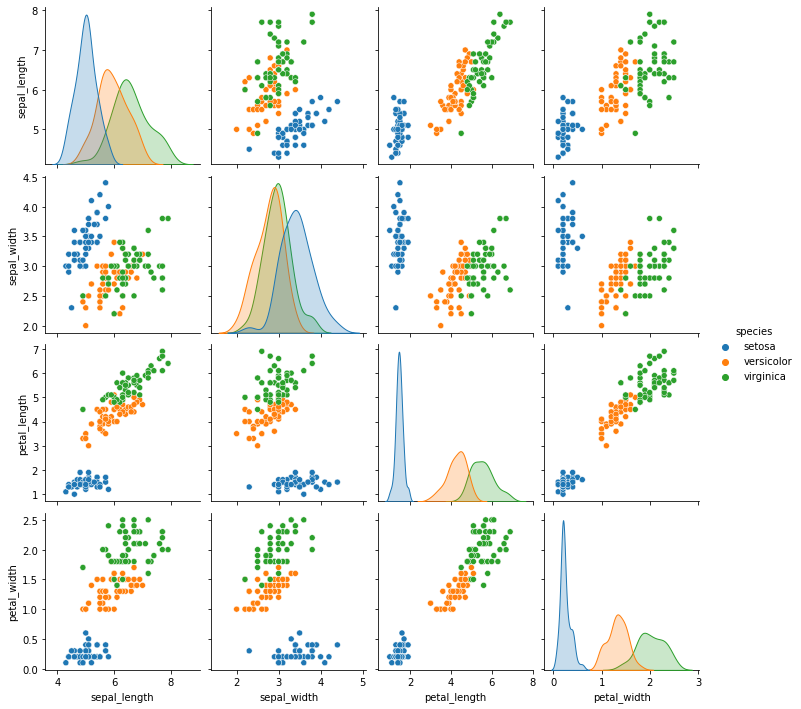

In [292]:
sns.pairplot(df, hue="species")

From just looking at these simple graphical representations of the features, we can already tell that the petal lengths and widths are likely better suited as potential features two separate between the three flower classes. In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique. For low-dimensional datasets like Iris, a glance at those histograms would already be very informative. Another simple, but very useful technique would be to use feature selection algorithms, which I have described in more detail in future lectures

## Normality assumptions

It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data: 

> "linear discriminant analysis frequently achieves good performances in
> the tasks of face and object recognition, even though the assumptions
> of common covariance matrix among groups and normality are often
> violated (Duda, et al., 2001)" (Tao Li, et al., 2006).

Tao Li, Shenghuo Zhu, and Mitsunori Ogihara. “[Using Discriminant Analysis for Multi-Class Classification: An Experimental Investigation](http://link.springer.com/article/10.1007%2Fs10115-006-0013-y).” Knowledge and Information Systems 10, no. 4 (2006): 453–72.)   

Duda, Richard O, Peter E Hart, and David G Stork. 2001. Pattern Classification. New York: Wiley.

## Preprocessing

In [293]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [294]:
X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y = df['species'].values 

enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)

# LDA in 6 steps

After we went through several preparation steps, our data is finally ready for the actual LDA. In practice, LDA for dimensionality reduction would be just another preprocessing step for a typical machine learning or pattern classification task.

## Step1: Center points

In [295]:
X = X - X.mean(axis=0) 

## Step 2: Computing the d-dimensional mean vectors

In this first step, we will start off with a simple computation of the mean vectors $\boldsymbol{\mu}_i$, $(i = 1,2,3)$ of the 3 different flower classes:
    
$\boldsymbol{\mu}_i = \begin{bmatrix} 
\mu_{\omega_i (\text{sepal length)}}\\ 
\mu_{\omega_i (\text{sepal width})}\\ 
\mu_{\omega_i (\text{petal length)}}\\
\mu_{\omega_i (\text{petal width})}\\
\end{bmatrix} \; , \quad \text{with} \quad i = 1,2,3$

In [296]:
np.set_printoptions(precision=4, suppress=True)

mean_vectors = []
for cl in range(0,3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [-0.8373  0.3707 -2.296  -0.9533]

Mean Vector class 1: [ 0.0927 -0.2873  0.502   0.1267]

Mean Vector class 2: [ 0.7447 -0.0833  1.794   0.8267]



##  Step 3: Computing the Scatter Matrices

Now, we will compute the two *4x4*-dimensional matrices: The within-class and the between-class scatter matrix.

### 3.1 Within-class scatter matrix $S_W$

The **within-class scatter** matrix $S_W$ is computed by the following equation:  

$S_W = \sum\limits_{i=1}^{c}  S_i$

where  
$S_i = \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb \mu_i)\;(\pmb x - \pmb \mu_i)^T$  
(scatter matrix for every class) 

and $\pmb \mu_i$ is the mean vector    
$\pmb \mu_i = \frac{1}{n_i} \sum\limits_{\pmb x \in D_i}^n \; \pmb x_k$

In [297]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


### 3.2 Between-class scatter matrix $S_B$

The **between-class scatter** matrix $S_B$ is computed by the following equation:  

$S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb \mu_i - \pmb \mu) (\pmb \mu_i - \pmb \mu)^T$

where  
 $\pmb \mu$ is the overall mean, and $\pmb \mu_{i}$ and $N_{i}$ are the sample mean and sizes of the respective classes.

In [298]:
overall_mean = np.mean(X, axis=0)


S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.9527 165.2484  71.2793]
 [-19.9527  11.3449 -57.2396 -22.9327]
 [165.2484 -57.2396 437.1028 186.774 ]
 [ 71.2793 -22.9327 186.774   80.4133]]


## Step 4: Solving the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$

Next, we will solve the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$ to obtain the linear discriminants.

In [299]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    #eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eig_vecs[:,i].real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[-0.2087 -0.3862  0.554   0.7074]
Eigenvalue 1: 3.22e+01

Eigenvector 2: 
[-0.0065 -0.5866  0.2526 -0.7695]
Eigenvalue 2: 2.85e-01

Eigenvector 3: 
[ 0.8825 -0.2639 -0.2357 -0.31  ]
Eigenvalue 3: 4.76e-15

Eigenvector 4: 
[-0.2844  0.4123  0.4716 -0.7258]
Eigenvalue 4: -8.19e-15


After this decomposition of our square matrix into eigenvectors and eigenvalues, let us briefly recapitulate how we can interpret those results. As we remember from our first linear algebra class in high school or college, both eigenvectors and eigenvalues are providing us with information about the distortion of a linear transformation: The eigenvectors are basically the direction of this distortion, and the eigenvalues are the scaling factor for the eigenvectors that describing the magnitude of the distortion.  

If we are performing the LDA for dimensionality reduction, the eigenvectors are important since they will form the new axes of our new feature subspace; the associated eigenvalues are of particular interest since they will tell us how "informative" the new "axes" are.  

Let us briefly double-check our calculation and talk more about the eigenvalues in the next section.

### Checking the eigenvector-eigenvalue calculation



A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

$\pmb A\pmb{v} =  \lambda\pmb{v}$  

<br>
where  
$\pmb A = S_{W}^{-1}S_B\\
\pmb{v} = \; \text{Eigenvector}\\
\lambda = \; \text{Eigenvalue}$

In [300]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1) 
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv), 
                                         eig_vals[i] * eigv, 
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


## Step 5: Selecting linear discriminants for the new feature subspace

### 5.1. Sorting the eigenvectors by decreasing eigenvalues



Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace). 

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.  
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [301]:
i = np.flip(np.argsort(eig_vals))

eig_vals=np.abs(eig_vals[i])
eig_vecs=eig_vecs[:,i]

eig_vals

array([32.1919,  0.2854,  0.    ,  0.    ])

In [302]:
print('Variance explained:\n')
eigv_sum = np.sum(eig_vals)
var_expl = eig_vals/eigv_sum

var_expl

Variance explained:



array([0.9912, 0.0088, 0.    , 0.    ])

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0. The reason why these are close to 0 is not that they are not informative but it's a floating-point imprecision. In fact, these two last eigenvalues should be exactly zero: In LDA, the number of linear discriminants is at most $c−1$ where $c$ is the number of class labels, since the in-between scatter matrix $S_B$ is the sum of $c$ matrices with rank 1 or less. Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

The first eigenpair is by far the most informative one, and we won't loose much information if we would form a 1D-feature spaced based on this eigenpair.

### 5.2. Choosing *k* eigenvectors with the largest eigenvalues

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our $d \times k$-dimensional eigenvector matrix $\pmb W$ (here $4 \times 2$: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [303]:
W = eig_vecs[:,0:2]
W

array([[-0.2087, -0.0065],
       [-0.3862, -0.5866],
       [ 0.554 ,  0.2526],
       [ 0.7074, -0.7695]])

# Step 6: Transforming the samples onto the new subspace

In the last step, we use the $4 \times 2$-dimensional matrix $\pmb W$ that we just computed to transform our samples onto the new subspace via the equation   

$\pmb Y = \pmb X \times \pmb W $.

(where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb Y$ are the transformed $n \times k$-dimensional samples in the new subspace).

In [304]:
X_lda = X.dot(W)
np.shape(X_lda)

(150, 2)

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant "LD1" separates the classes quite nicely. However, the second discriminant, "LD2", does not add much valuable information, which we've already concluded when we looked at the ranked eigenvalues is step 4.

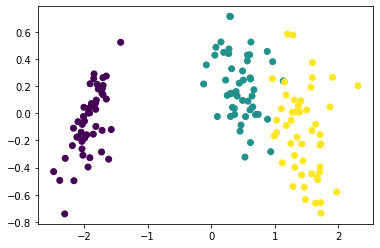

In [305]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='viridis')

# LDA via scikit-learn

Now, after we have seen how an Linear Discriminant Analysis works using a step-by-step approach, there is also a more convenient way to achive the same via the `LDA` class implemented in the [`scikit-learn`](http://scikit-learn.org/stable/) machine learning library.


In [306]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X, y)
X_lda = lda.transform(X)

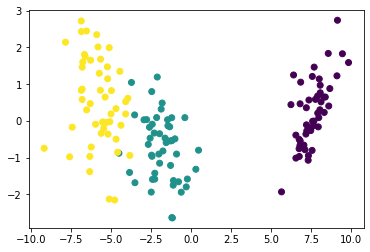

In [307]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='viridis')

# A comparison of PCA and LDA

In order to compare the feature subspace that we obtained via the Linear Discriminant Analysis, we will use the `PCA` class from the `scikit-learn` machine-learning library. The documentation can be found here:  
[https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py).  

For our convenience, we can directly specify to how many components we want to retain in our input dataset via the `n_components` parameter. 

In [308]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(X, y)
X_pca = pca.transform(X)

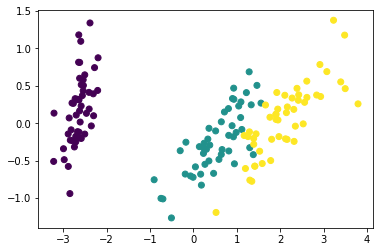

In [309]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')

# A Note About Standardization

Feature scaling such as [standardization] does **not** change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, the important part is that the eigenvalues will be exactly the same as well as the final projects -- the only difference you'll notice is the scaling of the component axes. This can be shown mathematically (I will insert the formulaes some time in future), and below is a practical, visual example for demonstration.